In [9]:
"""
This code makes diagnostic plots for raw and postprocessed WRF-Solar output
Postprocessing using the Kalman Filter is from Rafael Alvarenga's code (rafael.alvarenga@etu.univ-guyane.fr)
"""
import glob
import os
import numpy as np
import pandas as pd


import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import pytz
import datetime
import math

from tqdm import tqdm

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from numpy import dot
from numpy.linalg import inv

In [10]:
tz = pytz.timezone("Asia/Manila")
resolution = '10Min'

In [11]:
a = pd.read_csv('with_flags.csv')
a['Time'] = pd.to_datetime(a['Time'])

a['ghi_obs'] = a['SPN1_Total_Solar']
a.columns

Index(['Unnamed: 0', 'Time', 'CMP22_Total_Solar', 'SPN1_Total_Solar',
       'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni',
       'MM', 'DD', 'HH', 'mm', 'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
       'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
       'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
       'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear', 'ghi_obs'],
      dtype='object')

In [72]:
path = '/Users/apple/Desktop/Others/Python_Codes/wrf_solar/csv_2023_runs/' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))

mod_ = []

for f in all_files:
    mod = pd.read_csv(f)
    mod['Time'] = pd.to_datetime(mod['time'])#.dt.tz_localize(tz)
    mod = mod.set_index('Time')
    t0 = mod.index[0] + datetime.timedelta(hours=21)
    tf = t0 + datetime.timedelta(hours=14)
    mod['plot'] = 'N'
    mod.loc[((mod.index >= t0) & (mod.index<= tf)), 'plot'] = 'Y'
    mod=mod[mod['plot']=='Y']
    mod = mod.reset_index()
    mod_.append(mod)
    
mod_ = pd.concat(mod_)


mod_ = mod_[['Time', 'ens', 'ghi', 'swddni', 'coszen', 'swddif', 'lon', 'lat', 'hour', 'station_name',
       'domain']]


mod_ = pd.melt(mod_, id_vars=['Time', 'ens', 'domain', 'station_name'], value_vars=['ghi'] ,value_name='ghi_mod')


,Time,ens,ghi,swddni,coszen,swddif,lon,lat,hour,station_name,domain
0,2020-01-16 05:00:00+08:00,ens0,0.00000,0.00000,-0.323923,0.000000,121.05746,14.637177,5,MO,d01
1,2020-01-16 06:00:00+08:00,ens0,0.00000,0.00000,-0.090215,0.000000,121.05746,14.637177,6,MO,d01
2,2020-01-16 07:00:00+08:00,ens0,102.93088,533.80040,0.143482,26.339874,121.05746,14.637177,7,MO,d01
3,2020-01-16 08:00:00+08:00,ens0,340.62213,822.09890,0.361253,43.636078,121.05746,14.637177,8,MO,d01
4,2020-01-16 09:00:00+08:00,ens0,558.38104,924.73360,0.548264,51.382935,121.05746,14.637177,9,MO,d01
...,...,...,...,...,...,...,...,...,...,...,...
10,2020-02-11 15:00:00+08:00,ensmean,657.13855,975.52660,0.617437,54.812485,121.22297,14.067017,15,SOLARACE,d02
11,2020-02-11 16:00:00+08:00,ensmean,432.26648,902.23270,0.425724,48.164642,121.22297,14.067017,16,SOLARACE,d02
12,2020-02-11 17:00:00+08:00,ensmean,180.24013,700.76587,0.200897,39.458385,121.22297,14.067017,17,SOLARACE,d02
13,2020-02-11 18:00:00+08:00,ensmean,0.00000,0.00000,-0.041723,0.000000,121.22297,14.067017,18,SOLARACE,d02


In [13]:
#MO

#ensmean
mod_d01 = mod_[(mod_['ens']== 'ensmean') & (mod_['domain']== 'd01') & (mod_['station_name']== 'MO')]
mod_d02 = mod_[(mod_['ens']== 'ensmean') & (mod_['domain']== 'd02') & (mod_['station_name']== 'MO')]
mod_d01

,Time,ens,domain,station_name,variable,ghi_mod
120,2020-01-16 05:00:00+08:00,ensmean,d01,MO,ghi,0.00000
121,2020-01-16 06:00:00+08:00,ensmean,d01,MO,ghi,0.00000
122,2020-01-16 07:00:00+08:00,ensmean,d01,MO,ghi,102.70935
123,2020-01-16 08:00:00+08:00,ensmean,d01,MO,ghi,339.48013
124,2020-01-16 09:00:00+08:00,ensmean,d01,MO,ghi,556.75080
...,...,...,...,...,...,...
9880,2020-02-11 15:00:00+08:00,ensmean,d01,MO,ghi,648.91100
9881,2020-02-11 16:00:00+08:00,ensmean,d01,MO,ghi,427.68546
9882,2020-02-11 17:00:00+08:00,ensmean,d01,MO,ghi,180.44148
9883,2020-02-11 18:00:00+08:00,ensmean,d01,MO,ghi,0.00000


In [14]:
mod_d01.to_csv('sample.csv')

In [15]:
mod_d01  = mod_d01.set_index('Time')
mod_d01  = mod_d01.resample(resolution).interpolate(method='linear')
mod_d01  = mod_d01.reset_index(drop = False)
mod_d01['station_name']  = 'MO'
mod_d01['domain']  = 'd01'
mod_d01['ens']  = 'ensmean'

mod_d02  = mod_d02.set_index('Time')
mod_d02  = mod_d02.resample(resolution).interpolate(method='linear')
mod_d02  = mod_d02.reset_index(drop = False)
mod_d02['station_name']  = 'MO'
mod_d02['domain']  = 'd02'
mod_d02['ens']  = 'ensmean'

d01_mo_mean = a.merge(mod_d01, how='inner', on='Time')
d01_mo_mean['Time'] = pd.to_datetime(d01_mo_mean['Time']).dt.tz_convert(tz)


d01_mo_mean = d01_mo_mean.set_index('Time')
d01_mo_mean['YY'] = pd.DatetimeIndex(d01_mo_mean.index).year
d01_mo_mean['MM'] = pd.DatetimeIndex(d01_mo_mean.index).month
d01_mo_mean['DD'] = pd.DatetimeIndex(d01_mo_mean.index).day
d01_mo_mean['HH'] = pd.DatetimeIndex(d01_mo_mean.index).hour
d01_mo_mean['mm'] = pd.DatetimeIndex(d01_mo_mean.index).minute
d01_mo_mean = d01_mo_mean.reset_index()


d02_mo_mean = a.merge(mod_d02, how='inner', on='Time')
d02_mo_mean['Time'] = pd.to_datetime(d02_mo_mean['Time']).dt.tz_convert(tz)


d02_mo_mean = d02_mo_mean.set_index('Time')
d02_mo_mean['YY'] = pd.DatetimeIndex(d02_mo_mean.index).year
d02_mo_mean['MM'] = pd.DatetimeIndex(d02_mo_mean.index).month
d02_mo_mean['DD'] = pd.DatetimeIndex(d02_mo_mean.index).day
d02_mo_mean['HH'] = pd.DatetimeIndex(d02_mo_mean.index).hour
d02_mo_mean['mm'] = pd.DatetimeIndex(d02_mo_mean.index).minute
d02_mo_mean = d02_mo_mean.reset_index()


In [16]:
d01_mo_mean

,Time,Unnamed: 0,CMP22_Total_Solar,SPN1_Total_Solar,SPN1_Diff_Solar,CGR4_IR,dhi,ghi_a,sza,cossza,...,dhi_cc_val,t1_lim,flag_clear,ghi_obs,ens,domain,station_name,variable,ghi_mod,YY
0,2020-01-16 06:30:00+08:00,1004,0.016802,15.279198,11.717499,1202.902004,11.717499,15.279198,89.163074,0.014607,...,NaN,900,N,15.279198,ensmean,d01,MO,NaN,51.354675,2020
1,2020-01-16 06:40:00+08:00,1005,0.058873,49.183913,20.992307,1204.117039,20.992307,49.183913,87.104864,0.050508,...,NaN,900,N,49.183913,ensmean,d01,MO,NaN,68.472900,2020
2,2020-01-16 06:50:00+08:00,1006,0.065792,55.243904,23.202902,1204.582233,23.202902,55.243904,84.956502,0.087912,...,NaN,900,N,55.243904,ensmean,d01,MO,NaN,85.591125,2020
3,2020-01-16 07:00:00+08:00,1007,0.117346,100.511853,29.500008,1207.653611,29.500008,100.511853,82.782722,0.125632,...,NaN,900,N,100.511853,ensmean,d01,MO,ghi,102.709350,2020
4,2020-01-16 07:10:00+08:00,1008,0.155374,138.397671,34.556633,1211.386657,34.556633,138.397671,80.605436,0.163232,...,NaN,900,N,138.397671,ensmean,d01,MO,NaN,142.171147,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,2020-02-11 17:10:00+08:00,4814,0.059297,69.931744,44.257051,1235.070679,44.257051,69.931744,79.517432,0.181936,...,NaN,900,N,69.931744,ensmean,d01,MO,NaN,150.367900,2020
1810,2020-02-11 17:20:00+08:00,4815,0.028580,30.365263,28.386377,1229.536193,28.386377,30.365263,81.803756,0.142564,...,NaN,900,N,30.365263,ensmean,d01,MO,NaN,120.294320,2020
1811,2020-02-11 17:30:00+08:00,4816,0.016745,20.279092,18.880316,1227.709919,18.880316,20.279092,84.085972,0.103036,...,NaN,900,N,20.279092,ensmean,d01,MO,NaN,90.220740,2020
1812,2020-02-11 17:40:00+08:00,4817,0.011210,14.618756,13.509744,1226.630578,13.509744,14.618756,86.347644,0.063702,...,NaN,900,N,14.618756,ensmean,d01,MO,NaN,60.147160,2020


In [17]:
df = d01_mo_mean
if 'Error_rel' not in df.columns:
    # Function to calculate relative errors
    def calculate_relative_errors(pred, obs):
        if obs == 0:
            return np.nan
        else:
            return (pred - obs)/obs
    # recalculate relative error after removing some observations
    df['Error_rel'] = df.apply(lambda row : calculate_relative_errors(row['ghi_mod'], row['ghi_obs']), axis = 1)


In [18]:
#line 221
df['Kc_GHI_pred'] = df['ghi_mod']/df['GHI_in']
df['Kc_GHI_pred'] = df['Kc_GHI_pred'].replace(np.inf,np.nan)

##############################
#CHECK THIS###################
##############################
df['Kc_GHI_obs'] = df['ghi_obs']/df['GHI_in']

#line 223
# create clear-sky index column for observed errors 
df['Kc_obs_bias'] = df['Kc_GHI_pred'] - df['Kc_GHI_obs']




In [19]:

df['LT'] = (df['HH']*60)+df['mm']
df

,Time,Unnamed: 0,CMP22_Total_Solar,SPN1_Total_Solar,SPN1_Diff_Solar,CGR4_IR,dhi,ghi_a,sza,cossza,...,domain,station_name,variable,ghi_mod,YY,Error_rel,Kc_GHI_pred,Kc_GHI_obs,Kc_obs_bias,LT
0,2020-01-16 06:30:00+08:00,1004,0.016802,15.279198,11.717499,1202.902004,11.717499,15.279198,89.163074,0.014607,...,d01,MO,NaN,51.354675,2020,2.361085,131.332849,39.074545,92.258304,390
1,2020-01-16 06:40:00+08:00,1005,0.058873,49.183913,20.992307,1204.117039,20.992307,49.183913,87.104864,0.050508,...,d01,MO,NaN,68.472900,2020,0.392181,9.268698,6.657683,2.611015,400
2,2020-01-16 06:50:00+08:00,1006,0.065792,55.243904,23.202902,1204.582233,23.202902,55.243904,84.956502,0.087912,...,d01,MO,NaN,85.591125,2020,0.549332,3.216819,2.076262,1.140556,410
3,2020-01-16 07:00:00+08:00,1007,0.117346,100.511853,29.500008,1207.653611,29.500008,100.511853,82.782722,0.125632,...,d01,MO,ghi,102.709350,2020,0.021863,1.860553,1.820746,0.039807,420
4,2020-01-16 07:10:00+08:00,1008,0.155374,138.397671,34.556633,1211.386657,34.556633,138.397671,80.605436,0.163232,...,d01,MO,NaN,142.171147,2020,0.027265,1.590530,1.548314,0.042215,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,2020-02-11 17:10:00+08:00,4814,0.059297,69.931744,44.257051,1235.070679,44.257051,69.931744,79.517432,0.181936,...,d01,MO,NaN,150.367900,2020,1.150209,1.412651,0.656983,0.755668,1030
1810,2020-02-11 17:20:00+08:00,4815,0.028580,30.365263,28.386377,1229.536193,28.386377,30.365263,81.803756,0.142564,...,d01,MO,NaN,120.294320,2020,2.961577,1.740478,0.439340,1.301138,1040
1811,2020-02-11 17:30:00+08:00,4816,0.016745,20.279092,18.880316,1227.709919,18.880316,20.279092,84.085972,0.103036,...,d01,MO,NaN,90.220740,2020,3.448954,2.461774,0.553338,1.908436,1050
1812,2020-02-11 17:40:00+08:00,4817,0.011210,14.618756,13.509744,1226.630578,13.509744,14.618756,86.347644,0.063702,...,d01,MO,NaN,60.147160,2020,3.114383,4.750468,1.154601,3.595868,1060


In [20]:
# ----------------------------
#    Remove early morning and late afternoon
# ----------------------------
df_temp = df.loc[(df['Time'].dt.hour >= 8) & (df['Time'].dt.hour <= 17)].copy()
idx_remove = df_temp.loc[(df_temp['Time'].dt.hour == 17) & (df_temp['Time'].dt.minute != 0)].index
df_temp.drop(idx_remove, axis=0, inplace=True)
df_temp = df_temp.reset_index(drop = False)

In [21]:
#for predictors_vector in [['Kc_GHI_pred','Q2_rel']]:# [results_best_MBE.loc[results_best_MBE.index[-1], 'Predictors'].split('-')[1:], results_best_MAE.loc[results_best_MAE.index[-1], 'Predictors'].split('-')[1:]]:
#df_temp = df.copy()
df_temp['Kc_GHI_pred_improved'] = np.nan 

##############################
#CHECK THIS###################
##############################
df_temp['predicted_coefs'] = np.nan 
df_temp =  df_temp[['Time', 'LT','CMP22_Total_Solar', 'SPN1_Total_Solar',
       'SPN1_Diff_Solar', 'CGR4_IR', 'YY', 'MM', 'HH', 'mm', 'dhi',
       'ghi_obs', 'sza', 'cossza', 'dni',  'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
       'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
       'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
       'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear',\
         'ens', 'domain','station_name', 'ghi_mod', 'Error_rel', 'Kc_GHI_pred', 'Kc_GHI_obs', 'Kc_obs_bias',
       'Kc_GHI_pred_improved']]


In [23]:

nb_LTs = len(np.unique(df_temp.LT))

idx_t = 0
recursive_calculation_covariance_matrices = True
add_noise_in_predictions = False
nonlinear_predictions = False
predictors_vector = ['Kc_GHI_pred', 'cossza']

In [28]:
#for nb_historical_days in [2,3,4,5,6,7,9,11]:
#for nb_historical_days in [12,13,14,15,16,17,19,21]:
for nb_historical_days in [22,23,24,25]:
    for t in tqdm(range(len(df_temp))):

        hour = df_temp.loc[t,'Time'].hour
        minutes = df_temp.loc[t,'Time'].minute
        #print(f'Time: {lt_hours}:{lt_minutes:02d} (+{lt})')

        timestep_enough_historical = (nb_historical_days*2)*nb_LTs  
        
        if t >= timestep_enough_historical:
            # slice df
            df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()
        else:
            df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()
            df_timestep = df_timestep[::-1].reset_index(drop=True)
        df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]

        if (len(df_timestep) == 0) & (len(df_timestep) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices) or (t not in df_timestep.index)):
            df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
            continue

        df_timestep = df_timestep.iloc[-(nb_historical_days+1)-(nb_historical_days*recursive_calculation_covariance_matrices):,:]
        df_timestep = df_timestep.reset_index(drop = True)

        # define prediction-bias variance matrix
        W = np.eye(len(predictors_vector))/1000

        # define measurement-bias variance matrix
        V = 0.01

        # define initial error covariance matrix
        Po = np.eye(len(predictors_vector))*5

        # define initial predicted bias
        xo = np.zeros(len(predictors_vector)).reshape(len(predictors_vector),1)

        measurement_GHI = []
        old_predicted_GHI = []
        improved_GHI = []
        ground_truths = []
        predicted_coefs = []

        for idx_i, i in enumerate(df_timestep.index):
            if recursive_calculation_covariance_matrices == True:
                # --------------------------------------------
                #  Calculate matrices of covariance of errors
                # --------------------------------------------
                if idx_i > nb_historical_days:
                    mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                    mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                    # old method
                    W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                    V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))

                    # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                    # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                    # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))

            # ----------------------------
            #           Predict
            # ----------------------------

            if idx_i == 0:
                # predicted mean bias
                x_pred = np.zeros_like(xo)
                if add_noise_in_predictions == True:
                    x_pred = xo + np.random.multivariate_normal(mean=[0.5]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = xo

                # predicted bias covariance matrix
                P = Po + W

            else:
                # predicted mean bias
                if add_noise_in_predictions == True:
                    x_pred = x_pred + np.random.multivariate_normal(mean=[0]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = x_pred
                #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors

                # predicted bias covariance matrix
                P = P + W

            # ----------------------------
            #           Update
            # ----------------------------

            # compute transition matrix based on the current predictors for this timestep
            H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
            H = np.asarray([1] + H).reshape(1, len(predictors_vector))
            if nonlinear_predictions == True:
                H = [predictor**idx_predictor for idx_predictor, predictor in enumerate(H)]

            predicted_coefs.append(x_pred)
            improved_GHI.append(dot(H,x_pred))
            df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]

            # compute residual mean bias and residual bias covariance
            if add_noise_in_predictions == True:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs'] + np.random.normal(loc = 0, scale = V)
            else:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
            residual_mean = new_measurement - dot(H,x_pred)
            residual_covariance = dot(H, P).dot(H.T) + V

            # compute Kalman gain based on the transition matrix and residual covariance
            K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
            K = np.nan_to_num(K, nan = 0)

            # update mean bias after incorporating measurements
            x_pred = x_pred + dot(K,residual_mean)

            # update bias covariance matrix after incorporating measurements
            #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
            P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)

            measurement_GHI.append(new_measurement)
            old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
            ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])

        # assign final prediction
        df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
    # calculate overall error metrics for this group of predictors
    df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

    df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
    df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

    rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
    mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])

    print('\n\n**************************')
    print(f'{nb_historical_days}')
    print(f'- RMS: {rms}')
    print(f'- MAE: {mae}')
    print(f'- MSE: {mse}')
    print(f'- MBE: {mbe}')


100%|███████████████████████████████████████| 1446/1446 [00:37<00:00, 38.70it/s]




**************************
22
- RMS: 265.8118229707077
- MAE: 198.89507660716154
- MSE: 70655.92523101083
- MBE: -10.37127010243128


100%|███████████████████████████████████████| 1446/1446 [00:36<00:00, 40.00it/s]




**************************
23
- RMS: 265.92382884924695
- MAE: 199.5571657811635
- MSE: 70715.48274984359
- MBE: -9.056010618163663


100%|███████████████████████████████████████| 1446/1446 [00:35<00:00, 41.29it/s]




**************************
24
- RMS: 265.8543592531384
- MAE: 199.50073223068998
- MSE: 70678.54033389679
- MBE: -8.93940828051428


100%|███████████████████████████████████████| 1446/1446 [00:35<00:00, 40.30it/s]



**************************
25
- RMS: 265.8426071490389
- MAE: 199.42606317654878
- MSE: 70672.29177579822
- MBE: -8.983052606541827


In [105]:
nb_historical_days = 11
timestep_enough_historical = (nb_historical_days*2)*nb_LTs  
for t in tqdm(range(len(df_temp))):
    
    hour = df_temp.loc[t,'Time'].hour
    minutes = df_temp.loc[t,'Time'].minute
    #print(f'Time: {lt_hours}:{lt_minutes:02d} (+{lt})')
    
    
    if t >= timestep_enough_historical:
        # slice df
        df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()
    else:
        df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()
        df_timestep = df_timestep[::-1].reset_index(drop=True)
    df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]
    df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
    df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]

    if (len(df_timestep) == 0) & (len(df_timestep) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices) or (t not in df_timestep.index)):
        df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
        continue

    df_timestep = df_timestep.iloc[-(nb_historical_days+1)-(nb_historical_days*recursive_calculation_covariance_matrices):,:]
    df_timestep = df_timestep.reset_index(drop = True)
    
    # define prediction-bias variance matrix
    W = np.eye(len(predictors_vector))/1000
    
    # define measurement-bias variance matrix
    V = 0.01
        
    # define initial error covariance matrix
    Po = np.eye(len(predictors_vector))*5
    
    # define initial predicted bias
    xo = np.zeros(len(predictors_vector)).reshape(len(predictors_vector),1)
    
    measurement_GHI = []
    old_predicted_GHI = []
    improved_GHI = []
    ground_truths = []
    predicted_coefs = []
    
    for idx_i, i in enumerate(df_timestep.index):
        if recursive_calculation_covariance_matrices == True:
            # --------------------------------------------
            #  Calculate matrices of covariance of errors
            # --------------------------------------------
            if idx_i > nb_historical_days:
                mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                # old method
                W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))
                
                # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))
        
        # ----------------------------
        #           Predict
        # ----------------------------
    
        if idx_i == 0:
            # predicted mean bias
            x_pred = np.zeros_like(xo)
            if add_noise_in_predictions == True:
                x_pred = xo + np.random.multivariate_normal(mean=[0.5]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
            else:
                x_pred = xo
            
            # predicted bias covariance matrix
            P = Po + W
            
        else:
            # predicted mean bias
            if add_noise_in_predictions == True:
                x_pred = x_pred + np.random.multivariate_normal(mean=[0]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
            else:
                x_pred = x_pred
            #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors
            
            # predicted bias covariance matrix
            P = P + W
            
        # ----------------------------
        #           Update
        # ----------------------------
        
        # compute transition matrix based on the current predictors for this timestep
        H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
        H = np.asarray([1] + H).reshape(1, len(predictors_vector))
        if nonlinear_predictions == True:
            H = [predictor**idx_predictor for idx_predictor, predictor in enumerate(H)]
            
        predicted_coefs.append(x_pred)
        improved_GHI.append(dot(H,x_pred))
        df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
        
        # compute residual mean bias and residual bias covariance
        if add_noise_in_predictions == True:
            new_measurement = df_timestep.loc[i,'Kc_GHI_obs'] + np.random.normal(loc = 0, scale = V)
        else:
            new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
        residual_mean = new_measurement - dot(H,x_pred)
        residual_covariance = dot(H, P).dot(H.T) + V
        
        # compute Kalman gain based on the transition matrix and residual covariance
        K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
        K = np.nan_to_num(K, nan = 0)
        
        # update mean bias after incorporating measurements
        x_pred = x_pred + dot(K,residual_mean)
       
        # update bias covariance matrix after incorporating measurements
        #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
        P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)
        
        measurement_GHI.append(new_measurement)
        old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
        ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])
        
    # assign final prediction
    df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
# calculate overall error metrics for this group of predictors
df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])

print('\n\n**************************')
print(f'Predictors: {predictors_vector}')
print(f'- RMS: {rms}')
print(f'- MAE: {mae}')
print(f'- MSE: {mse}')
print(f'- MBE: {mbe}')


100%|███████████████████████████████████████| 1446/1446 [00:43<00:00, 33.05it/s]



**************************
Predictors: ['Kc_GHI_pred', 'cossza']
- RMS: 228.4881060342784
- MAE: 174.63878538924715
- MSE: 52206.81459913165
- MBE: -19.81242375969988


In [139]:
# assign post-processed timesteps to original dataframe
copy = df_temp[['Time','GHI_pred_improved']]


df_updated = df.merge(copy,how='outer',on="Time")
df_updated['kf_obs'] = np.abs(df_updated['GHI_pred_improved'] - df_updated['ghi_obs'])
df_updated['wrf_obs'] = np.abs(df_updated['ghi_mod'] - df_updated['ghi_obs'])
#recording HITs and MISS for each LT or time of the day (Contingency Table)
def lim(df):
    if ((df['GHI_pred_improved'] >= 0) & (df['kf_obs'] <= df['wrf_obs'])):
        lim = 'HIT' #by KF
    else:
        lim = 'MISS'
    return(lim)
           
df_updated["flag_hit"] = df_updated.apply(lim, axis=1)

table = df_updated.groupby(['LT','flag_hit']).agg({'flag_hit': ['count']}).droplevel(axis=1, level=0).reset_index()#.to_csv('summary.csv')
table = pd.pivot_table(table, values='count', index=['LT'],columns=['flag_hit']).reset_index()#.to_csv('summary.csv')

#this will be used to know whether the WRF or KF output is better for each LT or time of the day
def hit(t):
    if ((t['HIT'] >= 0) & (t['HIT'] >= t['MISS'])):
        hit = 'KF'
    else:
        hit = 'WRF'
    return(hit)
table["final"] = table.apply(hit, axis=1)

df_updated = df_updated.merge(table,how='outer',on="LT")
#depending on contingency table for each LT or time of the day 
#use KF or WRF output
def final_pred(df):
    if ((df['GHI_pred_improved'] >= 0) & (df['final'] == 'KF')):
        lim = df['GHI_pred_improved']
    else:
        lim = df['ghi_mod']
    return(lim)
           
df_updated["GHI_pred_improved_fin"] = df_updated.apply(final_pred, axis=1)
df_updated = df_updated.sort_values(by='Time').reset_index()

flag_hit,LT,HIT,MISS,final
0,390,NaN,27.0,WRF
1,400,NaN,27.0,WRF
2,410,NaN,27.0,WRF
3,420,NaN,27.0,WRF
4,430,NaN,27.0,WRF
...,...,...,...,...
64,1030,NaN,27.0,WRF
65,1040,NaN,27.0,WRF
66,1050,NaN,27.0,WRF
67,1060,NaN,27.0,WRF


In [142]:
df_updated = df_updated[['Time',  'CMP22_Total_Solar', 'SPN1_Total_Solar',
       'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni',
       'MM', 'DD', 'HH', 'mm', 'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
       'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
       'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
       'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear', 'ghi_obs',
       'ens', 'domain', 'station_name', 'variable', 'ghi_mod', 'YY',
       'Error_rel', 'Kc_GHI_pred', 'Kc_GHI_obs', 'Kc_obs_bias', 'LT',
       'GHI_pred_improved_fin']]

In [143]:
# calculate overall error metrics for this group of predictors
df_updated = df_updated.loc[~np.isnan(df_updated['GHI_pred_improved_fin'])]
df_updated = df_updated.loc[~np.isnan(df_updated['ghi_obs'])]

rms = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'], squared=False)
mae = mean_absolute_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
mse = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
mbe = np.mean(df_updated['GHI_pred_improved_fin'] - df_updated['ghi_obs'])

print('\n\n**************************')
print(f'Predictors: {predictors_vector}')
print(f'- RMS: {rms}')
print(f'- MAE: {mae}')
print(f'- MSE: {mse}')
print(f'- MBE: {mbe}')




**************************
Predictors: ['Kc_GHI_pred', 'cossza']
- RMS: 191.3832000133311
- MAE: 133.7050682472845
- MSE: 36627.529247342696
- MBE: 38.190301337498234


In [144]:
def fitting(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['ghi_mod'])
    xaa = x_a[~np.isnan(x_a)]
    print('Length ob:' + str(len(xaa)))
    yaa = y_a[~np.isnan(y_a)]
    print('Length obs:' + str(len(yaa)))
    #print(xaa,yaa)
    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

    print('Pearsons correlation: %.3f' % pearson_corr)
    print('Pearsons p_value: %.3f' % pearson_pval)
    print('RMS: %.3f' % rms)
    print('MAE: %.3f' % mae)
    print('###########################################')
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms)

def fitting_pred(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['GHI_pred_improved_fin'])
    xaa = x_a[~np.isnan(x_a)]
    print('Length pred:' + str(len(xaa)))
    yaa = y_a[~np.isnan(y_a)]
    print('Length pred:' + str(len(yaa)))
    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

    print('Pearsons correlation: %.3f' % pearson_corr)
    print('RMS: %.3f' % rms)
    print('MAE: %.3f' % mae)
    print('###########################################')
    
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms)


Length ob:1814
Length obs:1814
Kendall correlation coefficient: 0.596
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.753
Pearsons p_value: 0.000
RMS: 193.751
MAE: 136.402
###########################################
Length pred:1814
Length pred:1814
Kendall correlation coefficient: 0.566
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.712
RMS: 191.383
MAE: 133.705
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_11461/1045584618.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


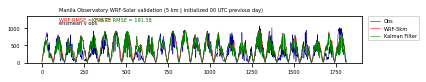

In [151]:
def ts(res, da_mean):
    fig = plt.figure()
    gs = fig.add_gridspec(4, 3)

    ax00 = fig.add_subplot(gs[0, 0:3])

    da_mean = da_mean#.iloc[nb_LTs*nb_historical_days:,:] #
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=0.5)

    ax00.plot(da_mean.index,da_mean['ghi_mod'],c='red',linewidth=0.5)
    ax00.plot(da_mean.index,da_mean['GHI_pred_improved_fin'],c='green',linewidth=0.5)
 
    ax00.tick_params(axis='both', which='major', labelsize=5)

    ax00.set_ylim(0,1360)



    ax00.text(100, 1500, 'Manila Observatory WRF-Solar validation (' + str(res)+' km | initialized 00 UTC previous day)',  fontsize=5)
    ax00.text(100, 1100, 'ensmean v obs',  fontsize=5)

    
    ax00.text( 100, 1200,'WRF RMSE = %0.2f'%fitting(da_mean)[7], fontsize=5, color='red')
    ax00.text( 300, 1200,'KF-WRF RMSE = %0.2f'%fitting_pred(da_mean)[7], fontsize=5, color='green')
  
  

    #ax00.legend(['WRF-5km','WRF-1.67km','Obs'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
    ax00.legend(['Obs','WRF-' + str(res) + 'km', 'Kalman Filter'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)


    images_dir = 'img/2023_runs'
    plt.savefig(f"{images_dir}/kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
ts(5, df_updated)


Length ob:1814
Length obs:1814
Kendall correlation coefficient: 0.596
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.753
Pearsons p_value: 0.000
RMS: 193.751
MAE: 136.402
###########################################
Length ob:1814
Length obs:1814
Kendall correlation coefficient: 0.596
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.753
Pearsons p_value: 0.000
RMS: 193.751
MAE: 136.402
###########################################
Length pred:1814
Length pred:1814
Kendall correlation coefficient: 0.566
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.712
RMS: 191.383
MAE: 133.705
###########################################
Length pred:1814
Length pred:1814
Kendall correlation coefficient: 0.566
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.712
RMS: 191.383
MAE: 133.705
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_11461/4114341032.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


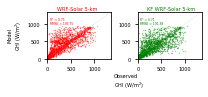

In [152]:
def scat(res, da_mean):   
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    x_new = np.linspace(0.01, 1360, 1000)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    plt_da = da_mean#.iloc[nb_LTs*nb_historical_days:,:] #
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='green',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='green')
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')
    
    images_dir = 'img/2023_runs'
    plt.savefig(f"{images_dir}/kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat(5, df_updated)


Length ob:1668
Length obs:1668
Kendall correlation coefficient: 0.572
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.718
Pearsons p_value: 0.000
RMS: 201.660
MAE: 145.198
###########################################
Length ob:1668
Length obs:1668
Kendall correlation coefficient: 0.572
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.718
Pearsons p_value: 0.000
RMS: 201.660
MAE: 145.198
###########################################
Length pred:1668
Length pred:1668
Kendall correlation coefficient: 0.559
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.694
RMS: 193.840
MAE: 136.626
###########################################
Length pred:1668
Length pred:1668
Kendall correlation coefficient: 0.559
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.694
RMS: 193.840
MAE: 136.626
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_11461/1748786278.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


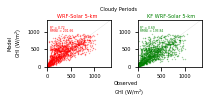

In [153]:
def scat_cloudy(res, da_mean):

    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    x_new = np.linspace(0.01, 1360, 1000)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    plt_da = da_mean#.iloc[nb_LTs*nb_historical_days:,:] #
    plt_da = plt_da[plt_da['flag_clear'] == 'N']
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='green',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='green')
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')
    ax00.text( -800, 1600,'Cloudy Periods', fontsize=5, color='k')
    
    images_dir = 'img/2023_runs'
    plt.savefig(f"{images_dir}/cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_cloudy(5, df_updated)


Length ob:146
Length obs:146
Kendall correlation coefficient: 0.928
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.992
Pearsons p_value: 0.000
RMS: 42.607
MAE: 35.911
###########################################
Length ob:146
Length obs:146
Kendall correlation coefficient: 0.928
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.992
Pearsons p_value: 0.000
RMS: 42.607
MAE: 35.911
###########################################
Length pred:146
Length pred:146
Kendall correlation coefficient: 0.695
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.847
RMS: 160.675
MAE: 100.330
###########################################
Length pred:146
Length pred:146
Kendall correlation coefficient: 0.695
Samples are correlated (reject H0) p=0.000
Pearsons correlation: 0.847
RMS: 160.675
MAE: 100.330
###########################################


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_11461/2269926949.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/clear_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


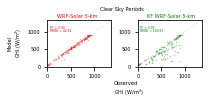

In [154]:
def scat_clear(res, da_mean):

    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    x_new = np.linspace(0.01, 1360, 1000)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    plt_da = da_mean#.iloc[nb_LTs*nb_historical_days:,:] #
    plt_da = plt_da[plt_da['flag_clear'] == 'Y']
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='green',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='green')
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')
    ax00.text( -800, 1600,'Clear Sky Periods', fontsize=5, color='k')
    
    images_dir = 'img/2023_runs'
    plt.savefig(f"{images_dir}/clear_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

scat_clear(5, df_updated)


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_11461/2196658002.py:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{images_dir}/timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


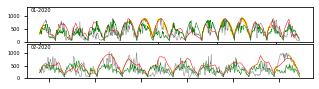

In [149]:
'''
subplot where each row is one month
y-axis 0-1400
x-axis 600 to 1900 LST
plot limits for clear-sky cases as per test 1
a) normalized total shortwave FN 
b) measured total shortwave and diffuse shortwave
'''
fig = plt.figure()
gs = fig.add_gridspec(18, 7)
    
  
for m in np.arange(1, 3, 1):
        
    sb = df_temp[(df_temp['MM']==m) ]
    
    #sb['SPN1_Total_Solar'] = sb['SPN1_Total_Solar'].replace(np.nan,0)
    #sb['t1_cc_val'] = sb['t1_cc_val'].replace(0,np.nan)
    if (m==1):
        i = 0

    if (m==2):
        i = 3


    ax00 = fig.add_subplot(gs[i:i+3, 0:6])
    plt.text(0.05, 0.9, f'{m:02}-2020', fontsize=5,horizontalalignment='center', verticalalignment='center', transform=ax00.transAxes)

    #ax00.plot(sb.index,sb['GHI_in'],c='gray',linewidth=0.5)
    ax00.scatter(sb.index,sb['ghi_cc_val'],marker='+',c='yellow',s=5)

    ax00.plot(sb.index,sb['ghi_obs'],c='gray',linewidth=0.5)

    ax00.plot(sb.index,sb['ghi_mod'],c='red',linewidth=0.5)
    ax00.plot(sb.index,sb['GHI_pred_improved'],c='green',linewidth=0.5)
    
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.xaxis.set_major_formatter(md.DateFormatter('%d'))
    ax00.set_xticklabels([])
    #ax00.set_xlim([datetime.date(2020, int(m), int(day))])
    
#ax00.set_ylabel('Total\nShortwave (W/m$^2$)',fontsize= 5)
#ax00.set_xlabel('Month-Day',fontsize= 5)

images_dir = 'img/2023_runs'
plt.savefig(f'{images_dir}/timeseries.png', dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

